# RAPIDS & Scanpy Single-Cell RNA-seq Workflow

Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

NVIDIA CORPORATION and its licensors retain all intellectual property
and proprietary rights in and to this software, related documentation
and any modifications thereto.  Any use, reproduction, disclosure or
distribution of this software and related documentation without an express
license agreement from NVIDIA CORPORATION is strictly prohibited.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.
For demonstration purposes, we use a dataset of ~70,000 human lung cells from Travaglini et al. 2020 (https://www.biorxiv.org/content/10.1101/742320v2) and label cells using the ACE2 and TMPRSS2 genes.

To install requirements: `conda install -c conda-forge -c rapidsai cudatoolkit=10.2 cudf=0.13 cuml=0.13 cugraph=0.13 paraview=5.8* dask=2.13* distributed=2.13* jupyterlab scanpy`

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import sys
import time
import os

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')

In [2]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client

bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


Client Scheduler: tcp://127.0.0.1:44337 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [4]:
start = time.time()

## Load and Prepare Data

We have saved our count matrix data as a sparse matrix in .h5ad format. This is much faster to load than a dense CSV file. To convert your CSV file into an `h5ad` file with a sparse count matrix, see `csv_to_sparse_h5ad.ipynb`

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [5]:
# Add path to input file here.
input_file = "krasnow_hlca_10x_UMIs.sparse.h5ad"

In [6]:
data_load_start = time.time()

In [7]:
%%time
adata = sc.read(input_file)
adata = adata.T

CPU times: user 3.21 s, sys: 973 ms, total: 4.19 s
Wall time: 4.05 s


In [8]:
adata.shape

(65662, 26485)

We maintain the index of unique cells and genes in our dataset:

In [9]:
%%time
cells = cudf.Series(adata.obs_names)
genes = cudf.Series(adata.var_names)

CPU times: user 778 ms, sys: 433 ms, total: 1.21 s
Wall time: 1.94 s


In [10]:
%%time
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

CPU times: user 213 ms, sys: 311 ms, total: 523 ms
Wall time: 570 ms


Verify the shape of the resulting sparse matrix:

In [11]:
sparse_gpu_array.shape

(65662, 26485)

And the number of non-zero values in the matrix:

In [12]:
sparse_gpu_array.nnz

126510394

In [13]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 6.613926887512207


## Preprocessing

In [14]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [15]:
%%time
filtered = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

Running 7 batches
CPU times: user 484 ms, sys: 689 ms, total: 1.17 s
Wall time: 1.14 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [16]:
%%time
filtered, genes = rapids_scanpy_funcs.filter_genes(filtered, genes, min_cells=1)

CPU times: user 858 ms, sys: 266 ms, total: 1.12 s
Wall time: 1.13 s


The size of our count matrix is now reduced.

In [17]:
filtered.shape

(65462, 22058)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [18]:
%%time
normalized = rapids_scanpy_funcs.normalize_total(filtered, target_sum=1e4)

CPU times: user 1.88 s, sys: 965 ms, total: 2.84 s
Wall time: 2.78 s


Next, we log transform the count matrix.

In [19]:
%%time
normalized = normalized.log1p()

CPU times: user 5.17 ms, sys: 2.07 ms, total: 7.24 ms
Wall time: 6.34 ms


### Select Most Variable Genes

We convert the count matrix to an annData object.

In [20]:
%%time
adata = anndata.AnnData(normalized.get())
adata.var_names = genes.to_pandas()

CPU times: user 206 ms, sys: 212 ms, total: 418 ms
Wall time: 406 ms


Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [21]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.6 s, sys: 148 ms, total: 1.75 s
Wall time: 1.73 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

Before regression, we save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of n epithelial marker gene (EPCAM).

In [22]:
%%time
tmp_norm = normalized.tocsc()
ACE2_raw = tmp_norm[:, genes[genes == "ACE2"].index[0]].todense().ravel()
TMPRSS2_raw = tmp_norm[:, genes[genes == "TMPRSS2"].index[0]].todense().ravel()
EPCAM_raw = tmp_norm[:, genes[genes == "EPCAM"].index[0]].todense().ravel()

del tmp_norm

CPU times: user 447 ms, sys: 188 ms, total: 635 ms
Wall time: 810 ms


In [23]:
genes = adata.var_names
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [24]:
%%time
filtered = adata.X

CPU times: user 486 ms, sys: 101 ms, total: 586 ms
Wall time: 572 ms


We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [25]:
%%time
n_counts = filtered.sum(axis=1)
percent_ribo = (filtered[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

CPU times: user 46.3 ms, sys: 1.34 ms, total: 47.7 ms
Wall time: 45.4 ms


And perform regression:

In [26]:
%%time
normalized = cp.array(adata.X.todense(), order="F")
normalized = rapids_scanpy_funcs.regress_out(normalized, n_counts, percent_ribo)

CPU times: user 7.8 s, sys: 7.21 s, total: 15 s
Wall time: 1min 37s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [27]:
%%time
normalized = rapids_scanpy_funcs.scale(normalized, max_value=10)

CPU times: user 36.4 ms, sys: 25.6 ms, total: 61.9 ms
Wall time: 146 ms


In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 106.18921446800232


## Cluster & Visualize

In [29]:
cluster_start = time.time()

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [30]:
%%time

var_names = adata.var_names
adata = anndata.AnnData(normalized.get())
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw.get()
adata.obs["EPCAM_raw"] = EPCAM_raw.get()

CPU times: user 285 ms, sys: 361 ms, total: 647 ms
Wall time: 627 ms


### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [31]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)

CPU times: user 1.26 s, sys: 443 ms, total: 1.7 s
Wall time: 2.14 s


In [32]:
adata.obsm["X_pca"].shape

(65462, 50)

### TSNE + K-means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [33]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

CPU times: user 1.22 s, sys: 1.18 s, total: 2.4 s
Wall time: 2.61 s


We cluster the cells using k-means on the principal components. For example purposes, we set k=20.

In [34]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 114 ms, sys: 40.4 ms, total: 155 ms
Wall time: 147 ms


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

... storing 'kmeans' as categorical


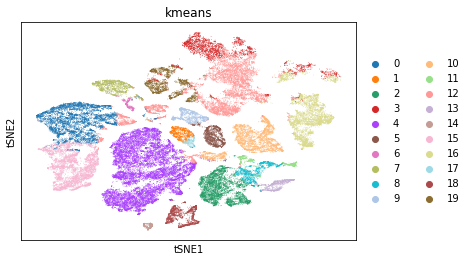

CPU times: user 651 ms, sys: 130 ms, total: 781 ms
Wall time: 683 ms


In [35]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

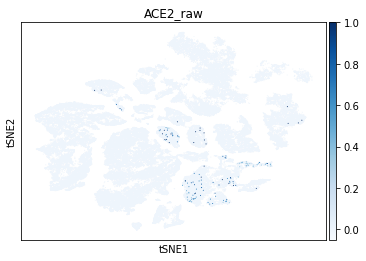

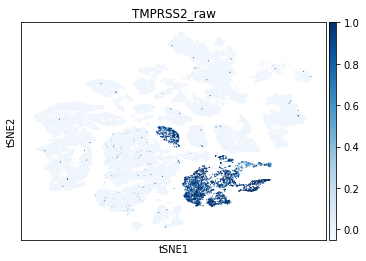

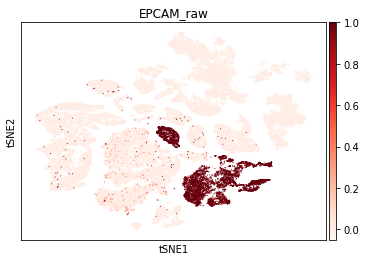

CPU times: user 1.18 s, sys: 383 ms, total: 1.57 s
Wall time: 1.19 s


In [36]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [37]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 5.38 s, sys: 319 ms, total: 5.7 s
Wall time: 5.79 s


The UMAP function from Rapids is also integrated into Scanpy.

In [38]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 673 ms, sys: 334 ms, total: 1.01 s
Wall time: 1.37 s


Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [39]:
%%time
sc.tl.louvain(adata, resolution=louvain_resolution, flavor='rapids')

CPU times: user 231 ms, sys: 48 ms, total: 279 ms
Wall time: 434 ms


/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/cugraph/structure/graph.py:329: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

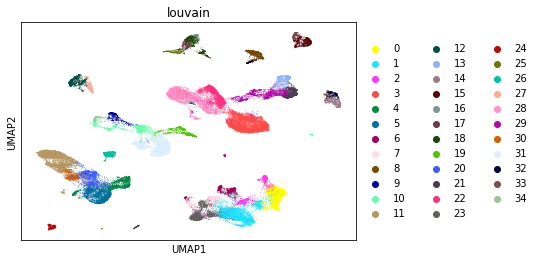

CPU times: user 843 ms, sys: 134 ms, total: 977 ms
Wall time: 838 ms


In [40]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

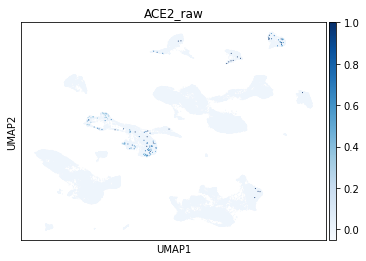

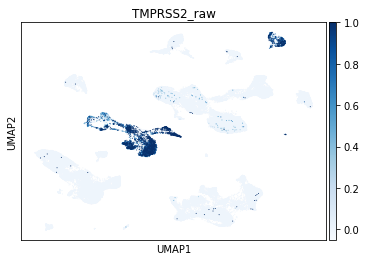

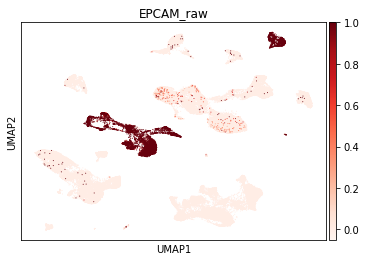

CPU times: user 1.37 s, sys: 354 ms, total: 1.72 s
Wall time: 1.32 s


In [41]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [42]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 17.221261501312256


## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [43]:
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(var_names)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [44]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    normalized, 
    cluster_labels, 
    var_names, 
    n_genes=ranking_n_top_genes, groups='all', reference='rest')

GPU Ranking took: 5.006854295730591
Created np.rec.fromarrays in: 16.890642404556274
CPU times: user 19.8 s, sys: 2.27 s, total: 22.1 s
Wall time: 22 s


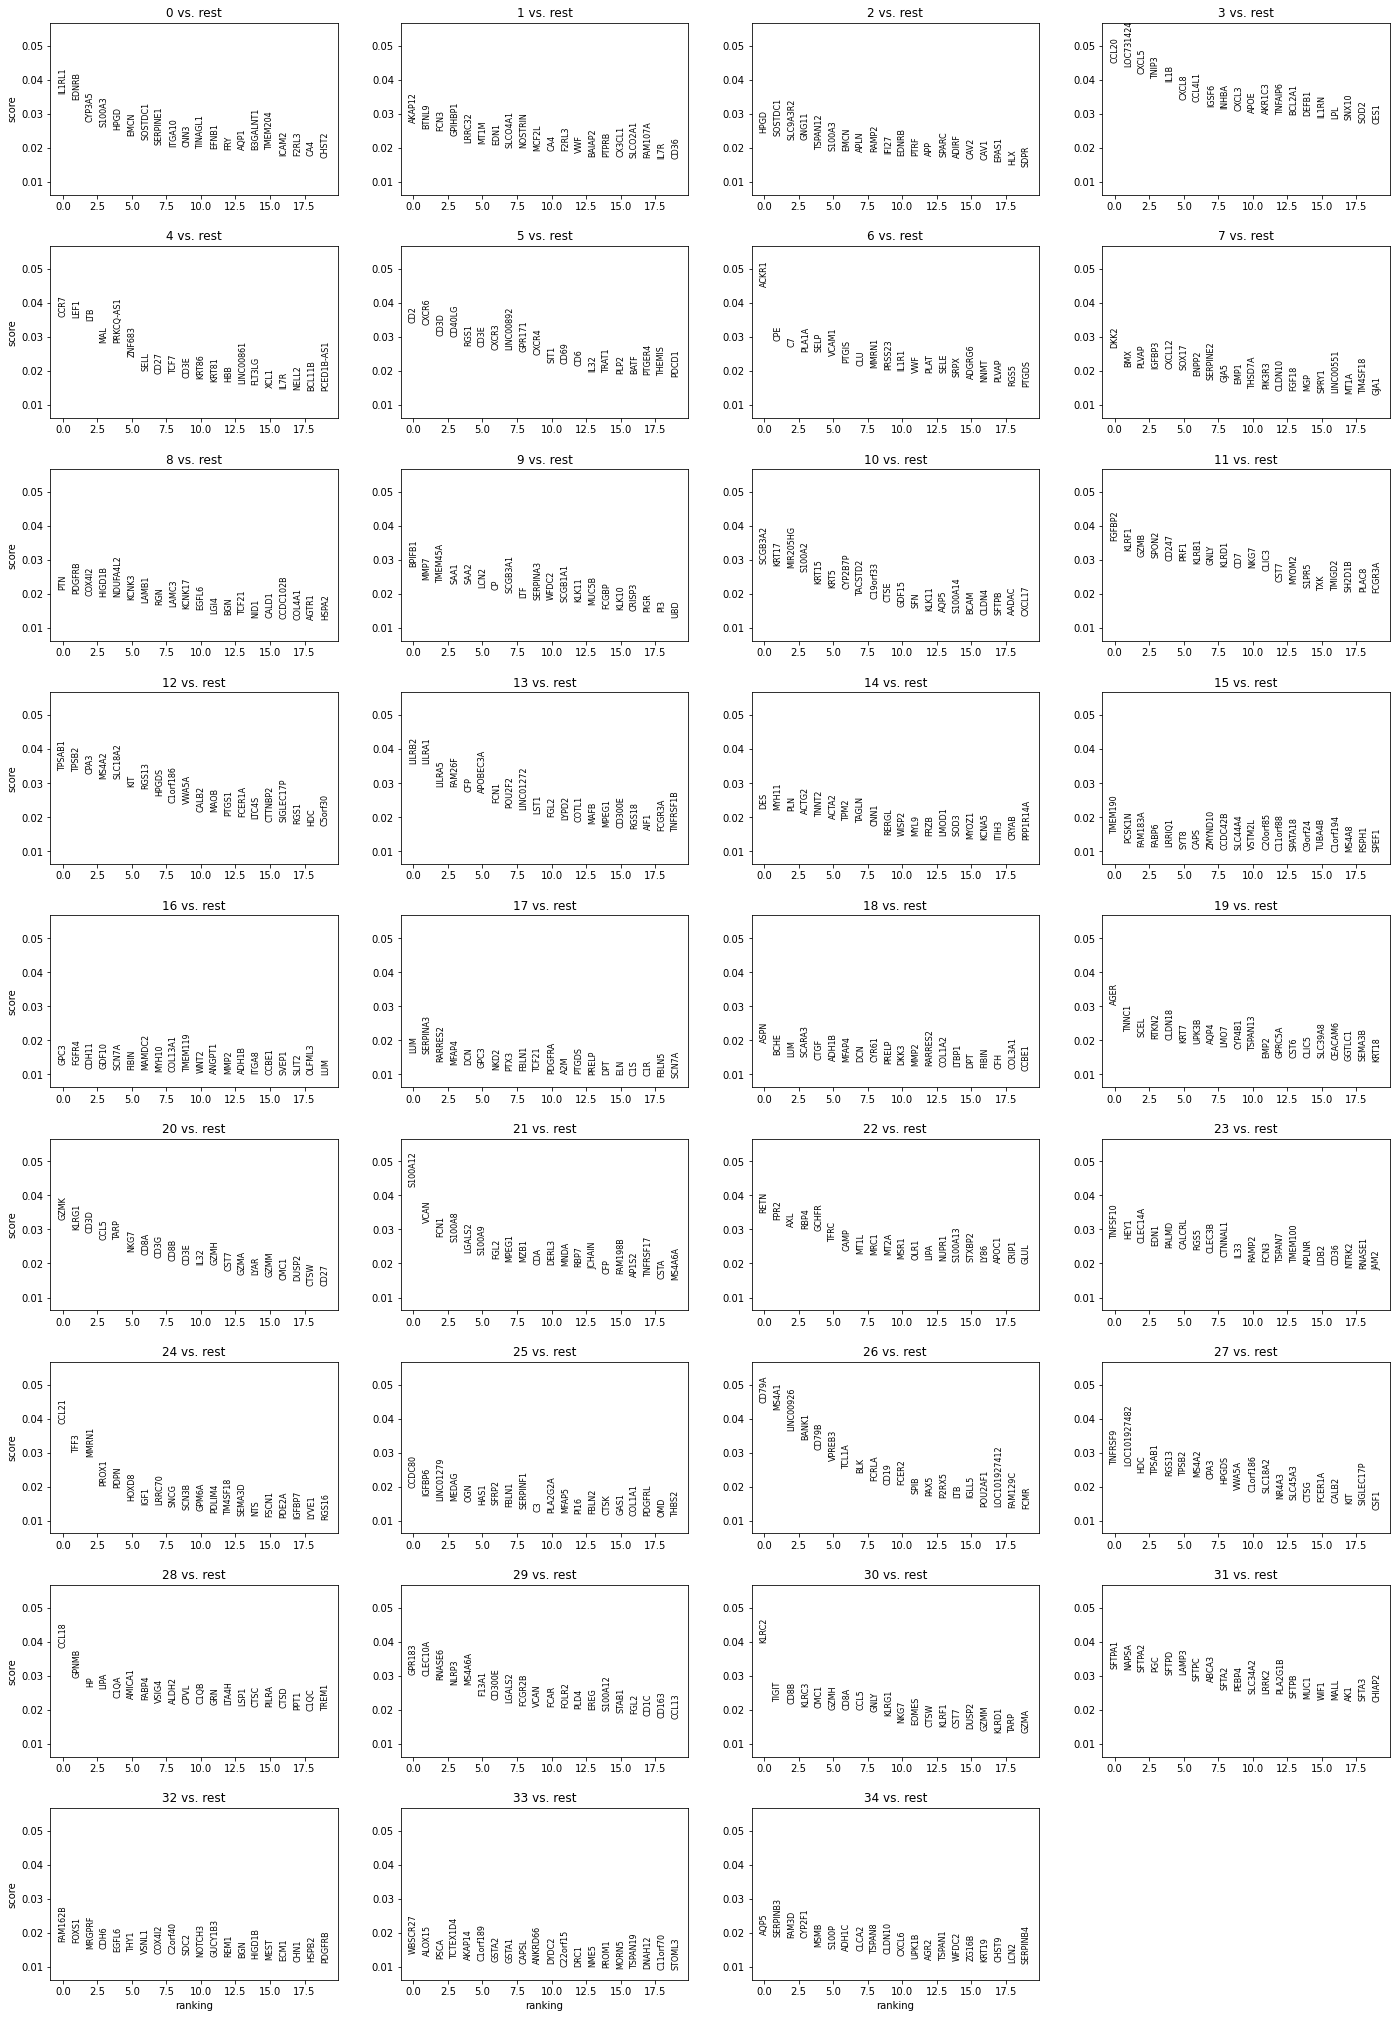

CPU times: user 5.78 s, sys: 394 ms, total: 6.17 s
Wall time: 5.96 s


In [45]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [46]:
reanalysis_start = time.time()

In [47]:
%%time

epcam_cells = EPCAM_raw > 0.0

normalized_epcam_cells = normalized[epcam_cells]
ACE2_raw_epcam = ACE2_raw[epcam_cells]
TMPRSS2_raw_epcam = TMPRSS2_raw[epcam_cells]

var_names = adata.var_names
adata = anndata.AnnData(normalized_epcam_cells.get())
print(adata.X.shape)
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw_epcam.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw_epcam.get()

(7958, 5000)
CPU times: user 54.7 ms, sys: 56.3 ms, total: 111 ms
Wall time: 109 ms


We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/cugraph/structure/graph.py:329: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


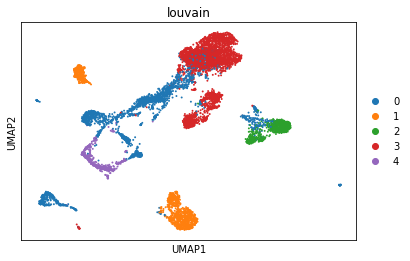

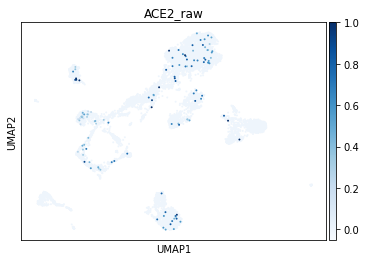

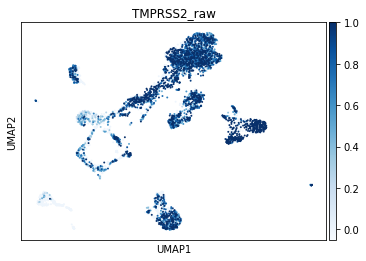

CPU times: user 12.6 s, sys: 1.4 s, total: 14 s
Wall time: 4.06 s


In [48]:
%%time

adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids', resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [49]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 4.190290927886963


In [50]:
print("Full time: %s" % (time.time() - start))

Full time: 162.2349021434784


In [51]:
client.close()
cluster.close()